In [0]:
''' comandi da usare quando si riavvia il notebook per caricare correttamente le nuvole'''
#!pip install --upgrade pillow
#dbutils.library.restartPython()
!pip install nltk wordcloud
from pyspark.sql import functions as F
from pyspark.sql import Row, Window
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

import nltk
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re

In [0]:
!wget https://proai-datasets.s3.eu-west-3.amazonaws.com/wikipedia.csv
import pandas as pd
dataset = pd.read_csv('/databricks/driver/wikipedia.csv')
spark_df = spark.createDataFrame(dataset)
spark_df = spark_df.drop("Unnamed: 0")
spark_df.write.mode("overwrite").saveAsTable("wikipedia")

In [0]:

'Colonne presenti nel dataset => title - summary - documents - categoria'

# DataFrame per operazioni successive
df = spark.table("wikipedia")


#  1 -  NUMERO ARTICOLI PER CATEGORIA (sql)
display(spark.sql("SELECT categoria, count(title) AS num_documenti FROM wikipedia GROUP BY categoria"))



categoria num_documenti finance 10157 energy 10046 culture 10372 science 10236 politics 11358 economics 10110 humanities 10236 medicine 10076 sports 10068 engineering 10220 technology 10095 transport 10130 pets 10023 research 10037 trade 10068

In [0]:

#   2 - NUM PAROLE MEDIE NEI DOC DIVISO PER CATEGORIA

# Funzione per pulire il testo
def pulisci_testo(testo):
    # Funzione per unire i numeri dell'ISBN
    def unisci_isbn(testo):
        return re.sub(r'isbn\s*([\d-]+)', lambda m: 'isbn ' + m.group(1).replace('-', ''), testo)
    
    # Verifica se il testo è una stringa, altrimenti restituisce una stringa vuota
    if not isinstance(testo, str):
        return ""
    
    testo = unisci_isbn(testo)
    # Rimuovi caratteri speciali
    testo_pulito = re.sub(r'[^a-zA-Z0-9\s]', ' ', testo)
    return testo_pulito


# Udf per applicare la funzione pulisci_testo in Spark
pulisci_udf = udf(pulisci_testo, StringType())

# Applica la UDF per creare una nuova colonna con il testo pulito
df_clean = df.withColumn("testo_pulito", pulisci_udf(df["documents"]))
df_clean= df_clean.withColumn("summary_pulito", pulisci_udf(df_clean["summary"]))

# Split delle parole nella nuova colonna "testo_pulito"
df_words = df_clean.withColumn("lista_parole", F.split(F.col("testo_pulito"), " "))

# Calcolo della lunghezza (numero di parole) per ogni articolo
df_word_count = df_words.withColumn("word_count", F.size(F.col("lista_parole")))

# Raggruppa per categoria e calcola la media del conteggio delle parole
df_grouped = df_word_count.groupBy("categoria").agg(
    F.round(F.mean("word_count"), 2).alias("avg_words")  # Calcola la media e arrotonda a 2 decimali
)

display(df_grouped)



categoria avg_words finance 2203.13 energy 695.31 culture 778.12 science 2288.81 politics 1775.4 economics 1201.79 humanities 1276.77 medicine 947.38 sports 718.64 engineering 861.15 technology 1061.2 transport 741.82 pets 499.59 research 848.55 trade 763.46

In [0]:

# 3 - CONTEGGIO PAROLE  articolo piu lungo e piu corto per ogni categoria

len_df = df_words.groupBy("categoria").agg(
    
    F.max(F.size(F.col("lista_parole"))).alias("max words"),
    F.min(F.size(F.col("lista_parole"))).alias("min words")
)

display(len_df)


categoria max words min words finance 39066 1 energy 26608 1 culture 18869 1 science 34523 1 politics 24379 18 economics 28354 19 humanities 27355 1 medicine 22179 1 sports 22363 1 engineering 13835 1 technology 21367 1 transport 26014 1 pets 15266 1 research 32178 1 trade 22849 1

In [0]:
# Unisci i documenti per categoria per il modello
documents_by_category = df_clean.groupBy("categoria").agg(
    F.concat_ws(" ", F.collect_list("testo_pulito")).alias("all_documents")
)


In [0]:

''' 4 - AGGIUNTIVO: Continuo l'exploration Analysis calcolando le frequenze delle parole per categoria prima di fare  la nuvola
per avere una view sulle n parole significative e sugli ordini di grandezza (frequenza globale per categoria e frequenze max e min per documento per poter scegliere i parametri del CountVectorizer) '''

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))  # lista stop words in inglese


# Funzione per calcolare la frequenza delle parole escludendo le stop words e i numeri
def word_frequencies(text):
    # Usa regex per ottenere solo le parole
    words = re.findall(r'\b[a-zA-ZàèìòùÀÈÌÒÙ]+\b', text.lower())  # Trova solo parole
    word_count = {}
    for word in words:
        if word not in stop_words:  # Rimuovi le stop words
            if word not in word_count:
                word_count[word] = 1
            else:
                word_count[word] += 1
    return word_count

# Crea un DataFrame per le parole e le loro frequenze
word_freq_list = []
for row in documents_by_category.collect():
    category = row["categoria"]
    all_documents = row["all_documents"]
    frequencies = word_frequencies(all_documents)
    for word, count in frequencies.items():
        word_freq_list.append(Row(categoria=category, parola=word, conteggio=count))

word_freq_df = spark.createDataFrame(word_freq_list)

# Raggruppa per categoria e parola per ottenere la somma delle frequenze
word_freq_df = word_freq_df.groupBy("categoria", "parola").agg(
    F.sum("conteggio").alias("conteggio")
)

# Mostra le parole più frequenti per categoria
word_freq_df.orderBy("categoria", "conteggio", ascending=False).show(truncate=False)


You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-45ea8953-743c-41b2-b687-e424bfef562e/bin/python -m pip install --upgrade pip' command.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


+---------+------------+---------+
|categoria|parola      |conteggio|
+---------+------------+---------+
|transport|station     |62612    |
|transport|bridge      |58365    |
|transport|line        |30642    |
|transport|new         |25388    |
|transport|airport     |23627    |
|transport|railway     |16022    |
|transport|also        |16004    |
|transport|two         |15519    |
|transport|city        |13171    |
|transport|terminal    |13142    |
|transport|opened      |12994    |
|transport|one         |12423    |
|transport|street      |11919    |
|transport|flight      |11680    |
|transport|construction|11450    |
|transport|services    |11358    |
|transport|first       |11345    |
|transport|would       |11307    |
|transport|south       |11149    |
|transport|air         |11076    |
+---------+------------+---------+
only showing top 20 rows



In [0]:

# TABELLA PER VISUALIZZARE LE N=10 PAROLE PIU FREQUENTI PER CATEGORIA


window = Window.partitionBy("categoria").orderBy(F.desc("conteggio"))
word_freq_df = word_freq_df.withColumn("rank", F.row_number().over(window))

# Filtro per ottenere solo le prime 'n' parole per ogni categoria
n = 10  # variabile 
top_words_per_category = word_freq_df.filter(F.col("rank") <= n)
display(top_words_per_category)



categoria parola conteggio rank finance series 91280 1 finance man 75095 2 finance company 55381 3 finance also 49236 4 finance one 44286 5 finance new 42718 6 finance universe 41939 7 finance masters 41342 8 finance first 36592 9 finance voiced 34919 10 medicine hospital 59880 1 medicine health 28992 2 medicine medical 27550 3 medicine new 26075 4 medicine university 25430 5 medicine also 22025 6 medicine medicine 20530 7 medicine research 20133 8 medicine first 17490 9 medicine school 14803 10 research research 48148 1 research university 38517 2 research medical 24457 3 research health 20981 4 research also 18259 5 research medicine 17743 6 research institute 17564 7 research national 15303 8 research science 13978 9 research new 13815 10 energy power 85360 1 energy station 38405 2 energy plant 34705 3 energy energy 31953 4 energy company 29875 5 energy electricity 26337 6 energy mw 21315 7 energy gas 19262 8 energy coal 16843 9 energy also 16815 10 technology game 40161 1 technology also 31163 2 technology linux 22071 3 technology software 21062 4 technology new 20370 5 technology released 20165 6 technology version 19789 7 technology system 19784 8 technology first 19029 9 technology one 18843 10 politics hanson 180331 1 politics party 165533 2 politics one 159757 3 politics nation 146992 4 politics election 116712 5 politics latham 112614 6 politics australia 85100 7 politics australian 84814 8 politics new 60886 9 politics queensland 55789 10 transport station 62612 1 transport bridge 58365 2 transport line 30642 3 transport new 25388 4 transport airport 23627 5 transport railway 16022 6 transport also 16004 7 transport two 15519 8 transport city 13171 9 transport terminal 13142 10 culture film 41597 1 culture meitei 34080 2 culture language 25229 3 culture also 21004 4 culture manipur 20903 5 culture khamba 16589 6 culture manipuri 15370 7 culture dance 14770 8 culture one 14033 9 culture india 13416 10 science aircraft 170380 1 science air 147813 2 science f 128666 3 science force 77787 4 science c 62355 5 science lockheed 61297 6 science two 50970 7 science flight 50599 8 science first 49023 9 science also 45688 10 humanities university 26915 1 humanities also 24489 2 humanities film 20229 3 humanities first 19269 4 humanities later 19136 5 humanities one 18752 6 humanities new 18627 7 humanities archaeology 15942 8 humanities time 15683 9 humanities history 15582 10 economics party 53654 1 economics university 33255 2 economics socialist 32716 3 economics new 27000 4 economics international 23210 5 economics also 23187 6 economics workers 21537 7 economics labour 18417 8 economics economic 17294 9 economics economics 17153 10 sports open 39483 1 sports first 35938 2 sports tennis 29072 3 sports doubles 26042 4 sports round 24718 5 sports singles 24236 6 sports final 22670 7 sports title 18907 8 sports world 18396 9 sports polo 16927 10 trade park 26715 1 trade national 21936 2 trade glacier 20231 3 trade river 19087 4 trade new 18550 5 trade also 18537 6 trade mountain 15898 7 trade fort 15508 8 trade lake 15056 9 trade company 14970 10 pets species 17214 1 pets dog 13941 2 pets also 13412 3 pets stadium 12250 4 pets greyhound 12075 5 pets breed 11796 6 pets cat 10646 7 pets first 10388 8 pets references 9994 9 pets fish 9906 10 engineering river 21480 1 engineering water 21394 2 engineering also 21232 3 engineering dresden 14971 4 engineering first 14679 5 engineering one 13353 6 engineering new 12096 7 engineering used 11432 8 engineering german 11412 9 engineering two 10903 10

In [0]:

# DELLE N PAROLE PIU FREQUENTI (per categoria) VEDIAMO IL NUM MAX E MIN DI OCCORRENZE PER SINGOLO DOCUMENTO

from pyspark.sql import functions as F
from pyspark.ml.feature import Tokenizer

# Campiona 1000 articoli per categoria
sampled_df = df_clean.groupBy("categoria").agg(F.collect_list("testo_pulito").alias("documenti")) \
                     .select("categoria", F.explode(F.expr("slice(documenti, 1, 1000)")).alias("documento"))

# tokenizzazione
tokenizer = Tokenizer(inputCol="documento", outputCol="words")
df_with_tokens = tokenizer.transform(sampled_df)

# Calcolo delle frequenze 
article_word_counts = []
for row in df_with_tokens.collect():
    category = row["categoria"]
    words = row["words"]
    
    word_count = {}
    for word in words:
        word = word.lower()
        if word not in word_count:
            word_count[word] = 1
        else:
            word_count[word] += 1
            
    for word, count in word_count.items():
        article_word_counts.append(Row(categoria=category, parola=word, conteggio=count))

# Creazione del DataFrame con le frequenze delle parole
article_word_count_df = spark.createDataFrame(article_word_counts)

# 5. Filtra solo le parole di top_words_per_category (top n parole)
filtered_word_df = article_word_count_df.join(
    top_words_per_category.select("categoria", "parola"), 
    on=["categoria", "parola"], 
    how="inner"
)

# 6. Calcolo delle statistiche min, max e media per parola e categoria
filtered_word_stats_df = filtered_word_df.groupBy("categoria", "parola").agg(
    F.min("conteggio").alias("min_count"),
    F.max("conteggio").alias("max_count"),
    F.mean("conteggio").alias("mean_count")
)

ordered_df= filtered_word_stats_df.orderBy("categoria", "parola")

In [0]:
# Frequenze minime e massime per documento di una categoria
display(ordered_df)

categoria parola min_count max_count mean_count culture also 1 18 2.2605531295487626 culture dance 1 4 1.7704918032786885 culture film 1 46 7.972972972972973 culture india 1 28 3.0816901408450703 culture khamba 1 175 35.5 culture language 1 132 3.894607843137255 culture manipur 1 59 3.65625 culture manipuri 1 49 4.151447661469933 culture meitei 1 162 5.17960088691796 culture one 1 19 2.942643391521197 economics also 1 63 3.2888283378746594 economics economic 1 110 6.3449197860962565 economics economics 1 166 7.156448202959831 economics international 1 73 3.258426966292135 economics labour 1 126 5.772151898734177 economics new 1 85 4.632352941176471 economics party 1 131 5.490196078431373 economics socialist 1 25 4.142857142857143 economics university 1 34 5.488235294117647 economics workers 1 35 3.9026548672566372 energy also 1 5 1.3836477987421383 energy coal 1 21 3.124590163934426 energy company 1 12 2.0868167202572345 energy electricity 1 17 1.9944444444444445 energy energy 1 14 1.6618497109826589 energy gas 1 12 3.076530612244898 energy mw 1 15 3.074424898511502 energy plant 1 34 4.933643771827707 energy power 1 31 8.216432865731463 energy station 1 26 3.884472049689441 engineering also 1 47 3.6351706036745406 engineering dresden 1 3 1.5 engineering first 1 38 3.9353383458646616 engineering german 1 15 2.6770186335403725 engineering new 1 27 3.9965694682675816 engineering one 1 28 3.3546712802768166 engineering river 1 5 1.4426229508196722 engineering two 1 22 2.665399239543726 engineering used 1 41 3.3535108958837774 engineering water 1 42 3.4655172413793105 finance also 1 24 3.0851063829787235 finance company 1 68 3.797169811320755 finance first 1 37 3.070588235294118 finance man 1 8 1.6588235294117648 finance masters 1 8 2.9 finance new 1 64 5.1469194312796205 finance one 1 74 3.3446327683615817 finance series 1 18 1.6693548387096775 finance universe 1 1 1.0 finance voiced 1 2 1.2222222222222223 humanities also 1 34 4.17971758664955 humanities archaeology 1 111 3.8181818181818183 humanities film 1 21 3.013888888888889 humanities first 1 45 3.5660377358490565 humanities history 1 225 4.194139194139194 humanities later 1 21 2.550724637681159 humanities new 1 49 4.624513618677042 humanities one 1 48 4.247272727272727 humanities time 1 99 3.6541019955654104 humanities university 1 78 5.836552748885587 medicine also 1 33 3.156657963446475 medicine first 1 18 2.7624113475177303 medicine health 1 273 6.942857142857143 medicine hospital 1 117 5.819070904645477 medicine medical 1 66 4.257342657342657 medicine medicine 1 55 4.560723514211887 medicine new 1 39 3.578767123287671 medicine research 1 29 5.028148148148148 medicine school 1 42 3.5338345864661656 medicine university 1 70 5.904642409033877 pets also 1 25 3.776796973518285 pets breed 1 61 13.761336515513127 pets cat 1 146 13.60348162475822 pets dog 1 95 9.010683760683762 pets first 1 36 4.8314814814814815 pets fish 1 13 2.108108108108108 pets greyhound 1 44 8.018867924528301 pets references 1 5 1.0446700507614213 pets species 1 33 3.8684210526315788 pets stadium 1 25 6.75 politics australia 1 139 10.535232383808095 politics australian 1 50 7.658342792281498 politics election 1 55 11.490049751243781 politics hanson 1 201 20.892473118279568 politics latham 2 207 38.6985294117647 politics nation 1 119 14.219288174512055 politics new 1 41 7.894651539708266 politics one 1 126 14.774403470715836 politics party 1 103 15.840989399293287 politics queensland 1 42 13.027173913043478 research also 1 33 3.1948051948051948 research health 1 53 3.836693548387097 research institute 1 37 3.689419795221843 research medical 1 44 5.219047619047619 research medicine 1 44 3.1166347992351815 research national 1 24 3.640322580645161 research new 1 45 2.4501061571125264 research research 1 214 8.390986601705238 research science 1 137 4.5 research university 1 61 3.9322033898305087 science air 1 41 3.9667896678966788 science aircraft 1 74 4.689655172413793 science also 1 42 4.408588957055215 scien

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


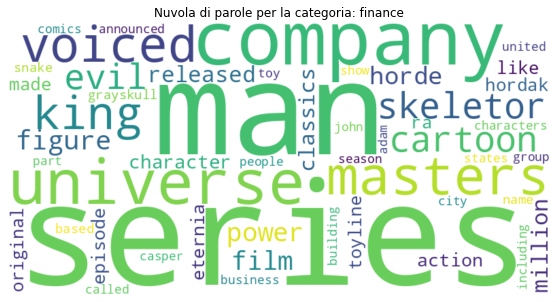

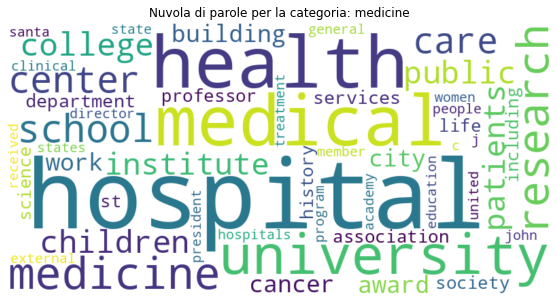

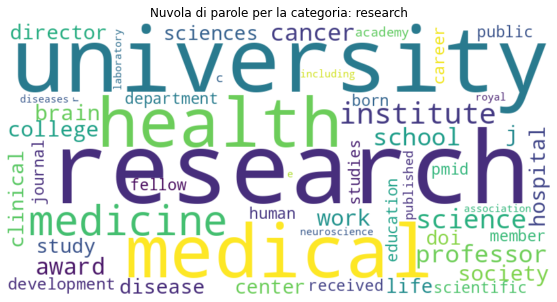

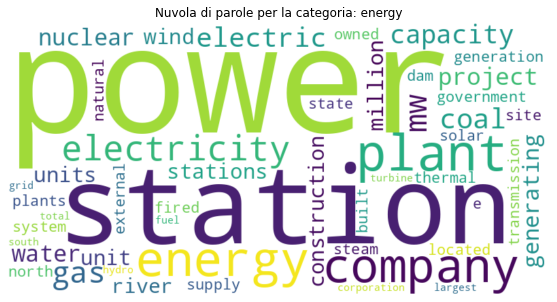

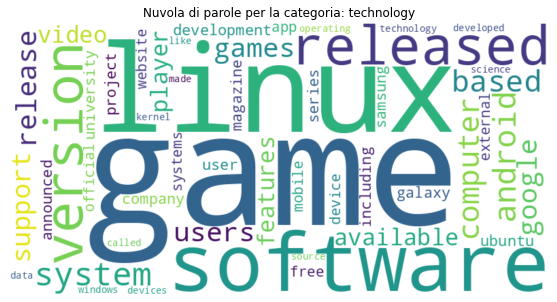

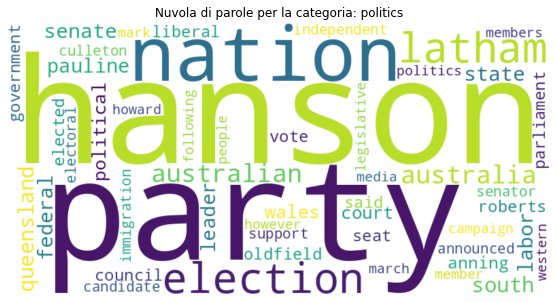

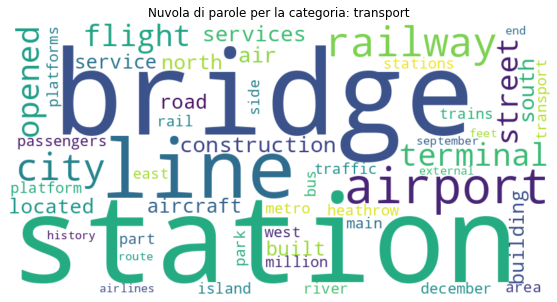

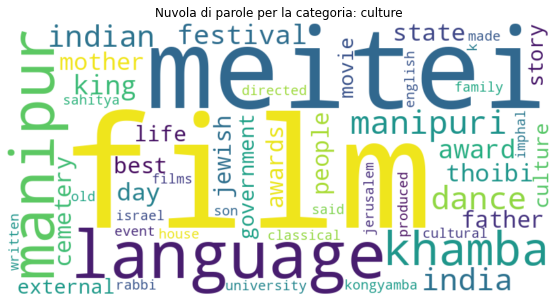

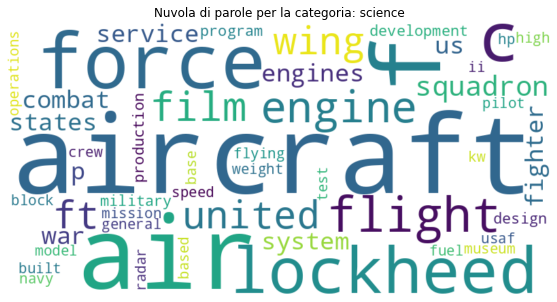

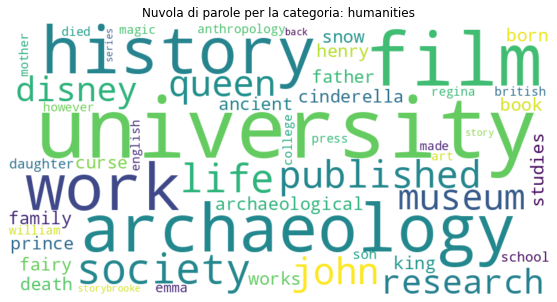

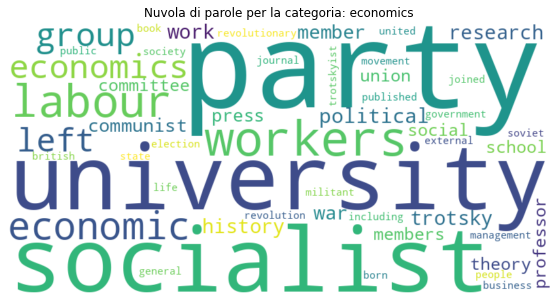

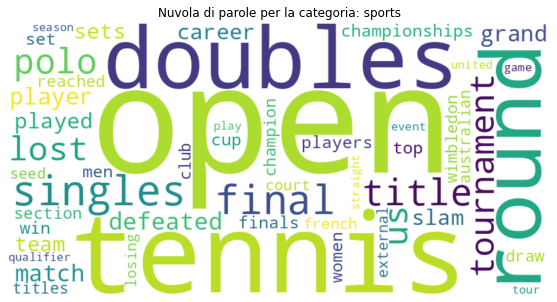

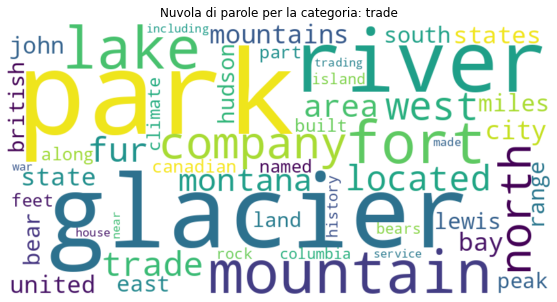

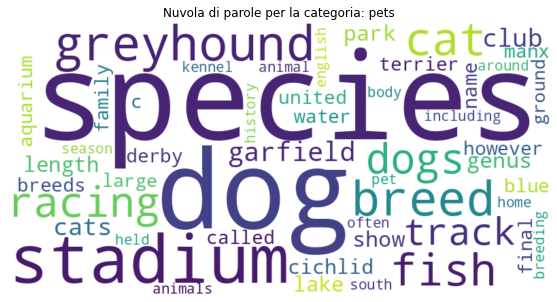

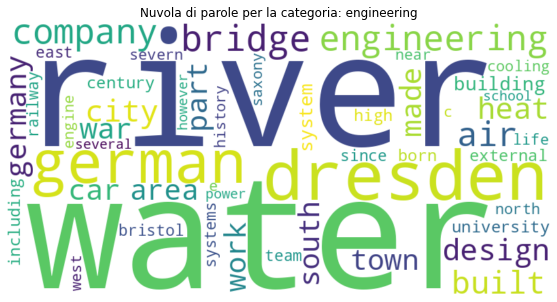

In [0]:
#  VISUALIZZAZIONE NUVOLE PER CATEGORIA

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Aggiungi altre stop words specifiche che hai identificato
additional_stop_words = {"one", "first", "two", "second", "three", "third", "four", "white", "black", "year", "years", 
                         "lb", "km", "kg", "later", "also", "isbn", "references", "de", "york", "time", "world", "may", 
                         "well", "long", "became", "small", "found", "would", "see", "new", "london", "american", "used", 
                         "using", "known", "canada", "national", "international", "links", "many", "un", "early", "use", 
                         "h", "b", "l", "u"}
stop_words.update(additional_stop_words)

# Funzione per filtrare le stop words da un dizionario di frequenze
def filter_stopwords(frequencies, stop_words):
    return {word: count for word, count in frequencies.items() if word.lower() not in stop_words}

# Crea un dizionario per le frequenze delle parole per categoria
category_wordcloud_data = {}

for row in word_freq_df.collect():
    category = row["categoria"]
    word = row["parola"]
    count = row["conteggio"]
    
    if category not in category_wordcloud_data:
        category_wordcloud_data[category] = {}
        
    category_wordcloud_data[category][word] = count

# Funzione per generare la nuvola di parole da frequenze
def generate_wordcloud_from_frequencies(frequencies, category, max_words=100):
    # Filtro le stop words
    filtered_frequencies = filter_stopwords(frequencies, stop_words)
    
    wordcloud = WordCloud(width=800, height=400, 
                          background_color='white', 
                          max_words=max_words).generate_from_frequencies(filtered_frequencies)
    
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Nuvola di parole per la categoria: {category}')
    plt.show()

# Itera attraverso le categorie e genera la nuvola di parole, filtrando le stop words
for category, freq_dict in category_wordcloud_data.items():
    generate_wordcloud_from_frequencies(freq_dict, category, max_words=50)


In [0]:
# Unione summary e documents puliti per il modello
united_text= df_clean.withColumn("testo_combinato", F.concat_ws(" ", "summary_pulito", "testo_pulito"))


In [0]:
# Librerie per modelling
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Preprocessing dei dati
tokenizer = Tokenizer(inputCol="testo_combinato", outputCol="words")
remover = StopWordsRemover(inputCol="words", outputCol="filtered")

# Rimozione di parole personalizzate
custom_stopwords = list(additional_stop_words)  # Aggiungi le stop words personalizzate
custom_remover = StopWordsRemover(inputCol="filtered", outputCol="custom_filtered", stopWords=custom_stopwords)

# Vettorizzazione ( minDF = n documenti minimo in cui deve essere presente , minTF= frequenza minima nel documento)
cv = CountVectorizer(inputCol="custom_filtered", outputCol="rawFeatures", minDF=5000, minTF=2, vocabSize=1000)  

idf = IDF(inputCol="rawFeatures", outputCol="features")

# Creazione di un indice per la colonna 'categoria'
indexer = StringIndexer(inputCol="categoria", outputCol="label")

# Modello di classificazione
lr = LogisticRegression(labelCol="label", predictionCol="prediction", maxIter=10, regParam=0.01)

# Creazione di una Pipeline
pipeline = Pipeline(stages=[tokenizer, remover, custom_remover, cv, idf, indexer, lr])

# Dividi i dati in un set di addestramento e un set di test
train_data, test_data = united_text.randomSplit([0.8, 0.2], seed=1234)

# Addestra il modello
model = pipeline.fit(train_data)

# Fai previsioni sul set di test
predictions = model.transform(test_data)

# Valuta il modello
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
  

In [0]:
print(f"Accuracy: {accuracy:.2f}")

# Usando un minDF=7000 e minTF=5 ottiene accuracy 0.62, soffrendo forse un filtro troppo invadente (alcune categorie hanno poche parole veramente identificative e hanno bisogno di più informazione per essere identificati)

# Ora abbassando i filtri abbiamo un ottimo livello 0.82 sul test

Accuracy: 0.82
